In [1]:
import numpy as np
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
#library of "traditional" methods
#theta0 is initial point

def gradient_descent(theta0, maxiter, stepsize, get_grad, get_obj):
    theta = theta0+0.
    thetatrack = [theta]
    f = [get_obj(theta)]
    for iter in xrange(maxiter):
        theta = theta - get_grad(theta)*stepsize
        f.append(get_obj(theta))
        thetatrack.append(theta)
    f = np.array(f)
    thetatrack = np.vstack(thetatrack)
    return thetatrack, f

def polyak_accel(theta0, maxiter, stepsize, get_grad, get_obj, beta = 0.8):
    theta = theta0+0.
    thetatrack = [theta]
    f = [get_obj(theta)]
    thetaprev = theta + 0.
    for iter in xrange(maxiter):
        thetanext = theta - get_grad(theta)*stepsize + beta*(theta - thetaprev)
        thetaprev = theta + 0.
        theta = thetanext + 0.
        f.append(get_obj(theta))
        thetatrack.append(theta)
    f = np.array(f)
    thetatrack = np.vstack(thetatrack)
    return thetatrack, f


def nesterov_accel(theta0, maxiter, stepsize, get_grad, get_obj):
    theta = theta0+0.
    thetatrack = [theta]
    f = [get_obj(theta)]
    thetayprev = theta
    lamprev = 0.
    for iter in xrange(maxiter):
        lam = (1. + np.sqrt(1.+4*lamprev**2.))/2.
        gam = (1.-lamprev)/lam

        thetay = theta - get_grad(theta)*stepsize
        theta = (1-gam)*thetay + gam*thetayprev

        thetayprev = thetay
        lamprev = lam

        f.append(get_obj(theta))
        thetatrack.append(theta)
    f = np.array(f)
    thetatrack = np.vstack(thetatrack)
    return thetatrack, f

def chebychev_accel(theta0, maxiter,  get_grad, get_obj, mu, L):
    rho =  (L - mu)/(L + mu)
    stepsize = 2./(L+mu)
    theta = theta0+0.
    thetatrack = [theta]
    f = [get_obj(theta)]
    w = 2.
    thetaprev = theta
    theta = theta - stepsize*get_grad(theta)
    for iter in xrange(maxiter):
        wnext = 1./(1. - rho**2./4.*w)

        thetanext = theta + (1 - wnext) *(thetaprev - theta) - wnext*stepsize*get_grad(theta)
        thetaprev = theta + 0.
        theta = thetanext + 0.

        f.append(get_obj(theta))
        thetatrack.append(theta)
    f = np.array(f)
    thetatrack = np.vstack(thetatrack)
    return thetatrack, f

def damped_Newton(theta0, maxiter, stepsize, get_Hessian, get_grad, get_obj):
    theta = theta0+0.
    thetatrack = [theta]
    f = [get_obj(theta)]
    for iter in xrange(maxiter):
        theta = theta - np.linalg.solve(get_Hessian(theta),get_grad(theta))/2.
        f.append(get_obj(theta))
        thetatrack.append(theta)
    f = np.array(f)
    thetatrack = np.vstack(thetatrack)
    return thetatrack, f


In [3]:
#Library of "more modern" methods


def adagrad(theta0, maxiter,  get_grad, get_obj):  
    theta, eta = theta0,  0.1
    eps = 1e-8
    v = theta * 0.

    thetatrack = [theta]
    f = [get_obj(theta)]
    for iter in xrange(maxiter):
        g = get_grad(theta)
        v += (g*g)

        theta = theta - np.divide(eta,np.sqrt(v + eps)) * g
        f.append(get_obj(theta))
        thetatrack.append(theta)
    f = np.array(f)
    thetatrack = np.vstack(thetatrack)
    return thetatrack, f
  


def rmsprop(theta0, maxiter,  get_grad, get_obj):  
         
    theta, eta = theta0,  0.1
    beta, eps = 0.9, 1e-8
    v = theta * 0.
    thetatrack = [theta]
    f = [get_obj(theta)]
    for iter in xrange(maxiter):
        g = get_grad(theta)
        v = beta * v + (1.-beta) * (g*g)

        theta = theta - np.divide(eta,np.sqrt(v + eps)) * g
        f.append(get_obj(theta))
        thetatrack.append(theta)
    f = np.array(f)
    thetatrack = np.vstack(thetatrack)
    return thetatrack, f
    


def adam(theta0, maxiter,  get_grad, get_obj):  

    theta, eta = theta0,  0.1
    eps, beta1, beta2 =  1e-8, 0.9, 0.99
    mom_cum, v_cum = theta*0.,theta*0.

    thetatrack = [theta]
    f = [get_obj(theta)]
    for iter in xrange(maxiter):
        g = get_grad(theta)

        mom_cum = beta1 * mom_cum + (1.-beta1) * g
        v_cum = beta2 * v_cum + (1.-beta2) * (g*g)

        mom = mom_cum/(1.-beta1**(iter+1.))
        v = v_cum/(1.-beta2**(iter+1.))

        theta = theta - np.divide(eta,np.sqrt(v + eps)) * mom
        f.append(get_obj(theta))
        thetatrack.append(theta)
    f = np.array(f)
    thetatrack = np.vstack(thetatrack)
    return thetatrack, f


In [10]:
class SimpleQuadraticProblem():
    def __init__(self, seed = None):
        if seed is not None:
            np.random.seed(seed)
        A = np.random.randn(2,2)
        A = np.dot(A,A.T)
        A = np.dot(A,A)
        self.A = A
        L = max(np.linalg.eig(A)[0])*1.1 # scaled up a bit to represent that in real life, this measurement is slightly noisy
        mu = min(np.linalg.eig(A)[0])*0.9 # scaled down a bit to represent that in real life, this measurement is slightly noisy
        self.L = L
        self.mu = mu
        self.Hessian = np.dot(A.T,A) # Since it's constant for all theta, we just precompute it once.
        self.set_contour()
        
    def set_contour(self):
        A = self.A
        xm = np.linspace(-10,10,200)
        xm,ym = np.meshgrid(xm,xm)
        zm = xm*(A[0,0]*xm + A[0,1]*ym) + ym*( A[1,0]*xm + A[1,1]*ym)
        self.xm = xm
        self.ym = ym
        self.zm = zm
    def plot_contour(self, nlines):
        plt.contour(self.xm,self.ym,self.zm,nlines)
        plt.axis([-10,10,-10,10])
        
    def get_grad(self,theta):
        return np.dot(self.A,theta)
    def get_obj(self,theta):
        return np.dot(theta.T,np.dot(self.A,theta))/2.
    def get_Hessian(self,theta):
        return self.Hessian

    
class StochasticQuadraticProblem():
    def __init__(self, seed = None, m = 100):
        if seed is not None: np.random.seed(seed)
        self.m = m
        Asgd = np.random.randn(2,2,m)
        A0 = np.random.randn(2,2)
        A0 = np.dot(A0,A0.T)
        A0 = np.dot(A0,A0)
        A0 = np.dot(A0,A0)
        L = 0.
        H = np.zeros((2,2))
        for k in xrange(m):
            a = np.reshape(Asgd[:,:,k],(2,2))
            a = np.dot(a,a.T)
            Asgd[:,:,k] = a  + A0*5.
            H = H + Asgd[:,:,k]
            a = np.reshape(Asgd[:,:,k],(2,2))
            L  += max(np.linalg.eig(a)[0])
        L = L/(m+0.) * 1.1
        
        self.Asgd = Asgd
        self.H = H
        self.L = L
        self.mu = 0.00001 # it is not realistic in this construct to know mu, so we just set it to some tiny number
        self.set_contour()
        self.idx = []

    def set_contour(self):
        Asgd = self.Asgd
        xm = np.linspace(-5,5,100)
        xm,ym = np.meshgrid(xm,xm)
        zm = xm * 0.
        for k in xrange(self.m):
            zm = zm + xm*(Asgd[0,0,k]*xm + Asgd[0,1,k]*ym) + ym*( Asgd[1,0,k]*xm + Asgd[1,1,k]*ym)
        zm = zm / (self.m+0.)
        
        self.xm = xm
        self.ym = ym
        self.zm = zm

    def plot_contour(self, nlines):
        plt.contour(self.xm,self.ym,self.zm,nlines)
        plt.axis([-5,5,-5,5])
        
        
    def get_grad(self,theta):
        if len(self.idx) == 0:
            self.idx = np.random.permutation(self.m)
        k = self.idx[0]
        self.idx = self.idx[1:]
        a = np.reshape(self.Asgd[:,:,k],(2,2))
        return np.dot(a,theta)

    def get_obj(self,theta):
        obj = 0.
        for k in xrange(self.m):
            a = np.reshape(self.Asgd[:,:,k],(2,2))
            obj += np.dot(theta.T,np.dot(a,theta))/2.
        return obj / (self.m + 0.)
    def get_Hessian(self,theta):
        return self.H





    

In [18]:

def sigmoid(s):
    return 1./(1.+np.exp(-s))

class LogisticRegression():
    def __init__(self, seed = None, m = 100):
        if seed is not None:
            np.random.seed(seed)
        
        X = np.random.randn(m,2)
        y = np.sign(np.random.randn(m))
        X = X + np.outer(y, np.random.randn(2))
        self.X, self.y = X,y
        
        
        Z = (X.T*y).T
        self.Z = Z
        self.L = max(np.linalg.eig(np.dot(Z.T,Z))[0])*1.1/4.
        self.mu = .000001 # in fact, mu = 0, but we need something nonzero for chebychev to run at all. So let's try fudging it. What's the worst that could happen.

        
        self.m = m
        
        self.set_contour()
    def set_contour(self):
        Z = self.Z
        xm = np.linspace(-20,20,200)
        xm,ym = np.meshgrid(xm,xm)
        zm = xm * 0.
        for k in xrange(self.m):
            zm += -np.log(sigmoid(Z[k,0]*xm + Z[k,1]*ym))/(self.m+0.)
        self.xm, self.ym, self.zm = xm, ym, zm
        
    def plot_contour(self, nlines):
        plt.contour(self.xm,self.ym,self.zm,nlines)
        plt.axis([-10,10,-10,10])
        
    def get_grad(self,theta):
        d = sigmoid(np.dot(self.Z,theta))
        return np.dot(self.Z.T,d-1.)
    def get_obj(self,theta):
        return -np.sum(np.log(sigmoid(np.dot(self.Z,theta))))/(self.m+0.)
    def get_Hessian(self,theta):
        Z = self.Z
        d = sigmoid(np.dot(Z,theta))
        H =  np.dot(Z.T*((1.-d)*d),Z)/(self.m+0.)
        return (H+H.T)/2.
    


In [49]:
class BraninFunction():
    def __init__(self):
        self.a = 1.
        self.b = 5.1/(4.*np.pi)
        self.c = 5./np.pi
        self.r = 6.
        self.s = 10.
        self.t = 1./(8*np.pi)
        
        
        xm = np.linspace(-5,10,100)
        ym = np.linspace(0,20,100)
        self.L = 0.
        for x in xm:
            for y in ym:
                xx = np.array([x,y])
                H = self.get_Hessian(xx)
                self.L = max(np.linalg.norm(H),self.L)
        self.mu = 0.0001 # since the function is not even convex, this is really fudgy

        self.set_contour()

        self.fstar = 0.397887 #optimal value
    
    


    def get_obj(self,theta1, theta2 = None):
        a,b,c,s,r,t = self.a, self.b, self.c, self.s, self.r, self.t
        if theta2 is None:
            theta2 = theta1[1]
            theta1 = theta1[0]
        return  a*np.power((theta2-b*np.power(theta1,2.)+c*theta1-r),2.) + s*(1.-t) * np.cos(theta1)+s



    def get_grad(self,theta):
        g = np.zeros(2)
        a,b,c,s,r,t = self.a, self.b, self.c, self.s, self.r, self.t
        g[0] = a * 2. * (theta[1]-b*np.power(theta[0],2.)+c*theta[0]-r)* (c - 2.*b*theta[0]) - s*(1.-t)*np.sin(theta[0])
        g[1] =  a * 2. * (theta[1]-b*theta[0]**2.+c*theta[0]-r)
        return g


    def get_Hessian(self,theta):
        a,b,c,s,r,t = self.a, self.b, self.c, self.s, self.r, self.t
        H = np.zeros((2,2))
        H[0,0] = a * 2. *  ((c - 2.*b*theta[0])**2.) -a * 4. * b*(theta[1]-b*theta[0]**2.+c*theta[0]-r)- s*(1.-t)*np.sin(theta[0])
        H[1,1] =  a * 2. 
        H[1,0] = a * 2. * (c - 2.*b*theta[0]) 
        H[0,1] = a * 2. * (c - 2.*b*theta[0]) 
        return H




    def set_contour(self):
        xm = np.linspace(-5,10,100)
        ym = np.linspace(0,20,100)
        xm,ym = np.meshgrid(xm,ym)
        zm = self.get_obj(xm,ym)
        self.xm, self.ym, self.zm = xm, ym, zm
        
    def plot_contour(self, nlines):
        plt.contour(self.xm,self.ym,self.zm,nlines)
        plt.axis([-5,10,0,20])

        


    
    
    

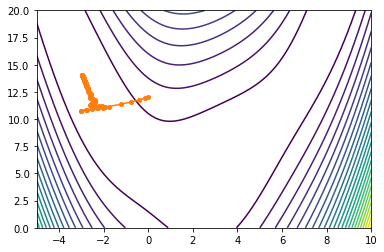

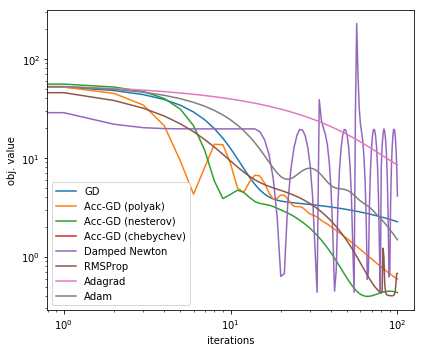

In [53]:

prob = SimpleQuadraticProblem(seed=0)
prob = StochasticQuadraticProblem(seed=0, m = 100)
prob = LogisticRegression(seed=0, m = 100)
prob = BraninFunction()

#recommended parameters for quadratic problems
maxiter = 250
theta0 = np.array([-10,10])*.8 # set some initial point

#recommended parameters for Logistic regression
theta0 = np.array([0,0.])
maxiter = 1000

#recommended parameters for Branin function
theta0 = np.array([0,12])
maxiter = 100


thetatrack = [None for k in xrange(8)]
ftrack = [None for k in xrange(8)]

stepsize = 1./prob.L
thetatrack[0], ftrack[0] = gradient_descent(theta0, maxiter, stepsize, prob.get_grad, prob.get_obj)
thetatrack[1], ftrack[1] = polyak_accel(theta0, maxiter, stepsize, prob.get_grad, prob.get_obj, beta = 0.8)
thetatrack[2], ftrack[2] = nesterov_accel(theta0, maxiter, stepsize, prob.get_grad, prob.get_obj)
#thetatrack[3], ftrack[3] = chebychev_accel(theta0, maxiter, prob.get_grad, prob.get_obj, mu=prob.mu, L = prob.L)
thetatrack[4], ftrack[4] = damped_Newton(theta0, maxiter, stepsize, prob.get_Hessian, prob.get_grad, prob.get_obj)
thetatrack[5], ftrack[5] = rmsprop(theta0, maxiter, prob.get_grad, prob.get_obj)
thetatrack[6], ftrack[6] = adagrad(theta0, maxiter, prob.get_grad, prob.get_obj)
thetatrack[7], ftrack[7] = adam(theta0, maxiter, prob.get_grad, prob.get_obj)



#plot the trajectory of theta
#I recommend uncommenting each experiment one at a time
plt.figure(1)
plt.clf()
prob.plot_contour(nlines=25)
#plt.plot(thetatrack[0][:,0],thetatrack[0][:,1],marker = '.',markersize=8,color=colors[0]) 
plt.plot(thetatrack[1][:,0],thetatrack[1][:,1],marker = '.',markersize=8,color=colors[1]) 
#plt.plot(thetatrack[2][:,0],thetatrack[2][:,1],marker = '.',markersize=8,color=colors[2]) 
#plt.plot(thetatrack[3][:,0],thetatrack[3][:,1],marker = '.',markersize=8,color=colors[3]) 
#plt.plot(thetatrack[4][:,0],thetatrack[4][:,1],marker = '.',markersize=8,color=colors[4]) 
#plt.plot(thetatrack[5][:,0],thetatrack[5][:,1],marker = '.',markersize=8,color=colors[5]) 
#plt.plot(thetatrack[6][:,0],thetatrack[6][:,1],marker = '.',markersize=8,color=colors[6]) 
#plt.plot(thetatrack[7][:,0],thetatrack[7][:,1],marker = '.',markersize=8,color=colors[7]) 


#plot the evolution of the objective value (true global minimum f(0) = 0)
#This is more fun to visualize all at once
legendstring = ['GD','Acc-GD (polyak)', 'Acc-GD (nesterov)', 'Acc-GD (chebychev)', 'Damped Newton', 'RMSProp', 'Adagrad','Adam']
plt.figure(2,figsize = (6,5))
for f in ftrack:
    if f is None:
        plt.plot([],[])
    else:
        plt.loglog(f)
plt.xlabel('iterations')
plt.ylabel('obj. value')
plt.tight_layout()
plt.legend(legendstring)
    


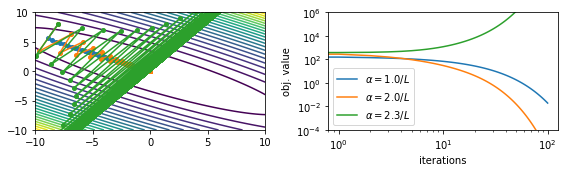

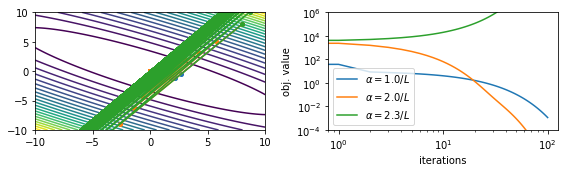

In [52]:
#Playing around with step size and initial conditions



prob = SimpleQuadraticProblem(seed=0)

maxiter = 100

alpha = [1.,2.,2.3]

  
#let's start on a steep side, taking progressively bigger steps
theta0 = np.array([-10,10])*.8
plt.figure(1,figsize = (8,2.5))
plt.subplot(1,2,1)
prob.plot_contour(nlines = 25)
for i in [0,1,2]:
    plt.subplot(1,2,1)
    thetatrack, ftrack = gradient_descent(theta0, maxiter, alpha[i]/prob.L, prob.get_grad, prob.get_obj)
    plt.plot(thetatrack[:,0],thetatrack[:,1],marker = '.',markersize=8,color=colors[i]) 
    plt.axis([-10,10,-10,10])
    
    
    plt.subplot(1,2,2)
    plt.loglog(ftrack,color=colors[i])
    plt.xlabel('iterations')
    plt.ylabel('obj. value')
    plt.ylim([.0001,1000000])
plt.legend(['$\\alpha = %.1f/ L$' % a for a in alpha])    
plt.tight_layout()

#Now let's start on a shallow side, taking progressively bigger steps
theta0 = np.array([10,10])*.8
plt.figure(2,figsize = (8,2.5))
plt.subplot(1,2,1)
prob.plot_contour(nlines = 25)
for i in [0,1,2]:
    plt.subplot(1,2,1)
    thetatrack, ftrack = gradient_descent(theta0, maxiter, alpha[i]/prob.L, prob.get_grad, prob.get_obj)
    plt.plot(thetatrack[:,0],thetatrack[:,1],marker = '.',markersize=8,color=colors[i]) 
    plt.axis([-10,10,-10,10])
    
    
    plt.subplot(1,2,2)
    plt.loglog(ftrack,color=colors[i])
    plt.xlabel('iterations')
    plt.ylabel('obj. value')
    plt.ylim([.0001,1000000])
plt.legend(['$\\alpha = %.1f/ L$' % a for a in alpha])    
plt.tight_layout()